## Imports

In [1]:
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications import vgg16
from keras.layers import Dense,Flatten,BatchNormalization,Dropout,Lambda,Input,Convolution2D
from keras.layers import MaxPooling2D
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.utils.visualize_util import plot
from keras_tqdm import TQDMNotebookCallback
import keras
import keras_tqdm
from keras.utils.np_utils import to_categorical

from glob import glob
import os
import bcolz


import matplotlib.pyplot as plt
from PIL import Image

import numpy as np

%matplotlib inline

Using TensorFlow backend.


## Create validation set and sample

In [27]:
HOMEDIR= '/home/vishnu/Documents/dogsandcats1/data/'



In [ ]:
#Create directories
%mkdir valid
%mkdir results

In [32]:
cd train/

/home/vishnu/Documents/dogsandcats1/data/train


In [35]:
f = glob('*.jpg')
shuffled = np.random.permutation(f)

In [37]:
for img in shuffled[:2000]:os.rename(HOMEDIR+'train/'+img,HOMEDIR+'valid/'+img)

In [38]:
shuffled[:10]

array(['cat.7867.jpg', 'cat.10830.jpg', 'cat.12204.jpg', 'dog.879.jpg',
       'cat.6506.jpg', 'dog.8487.jpg', 'dog.4756.jpg', 'cat.5843.jpg',
       'dog.5342.jpg', 'dog.2340.jpg'],
      dtype='<U13')

### Rearrange image files into their respective directories

In [39]:
%cd $HOMEDIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $HOMEDIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/vishnu/Documents/dogsandcats1/data/valid
/home/vishnu/Documents/dogsandcats1/data/train


## Data Generator

In [2]:
gen = image.ImageDataGenerator()
batches = gen.flow_from_directory('data/train/',batch_size=64,target_size=(224,224))
val_batches = gen.flow_from_directory('data/valid/',batch_size=64,shuffle=False,target_size=(224,224))

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


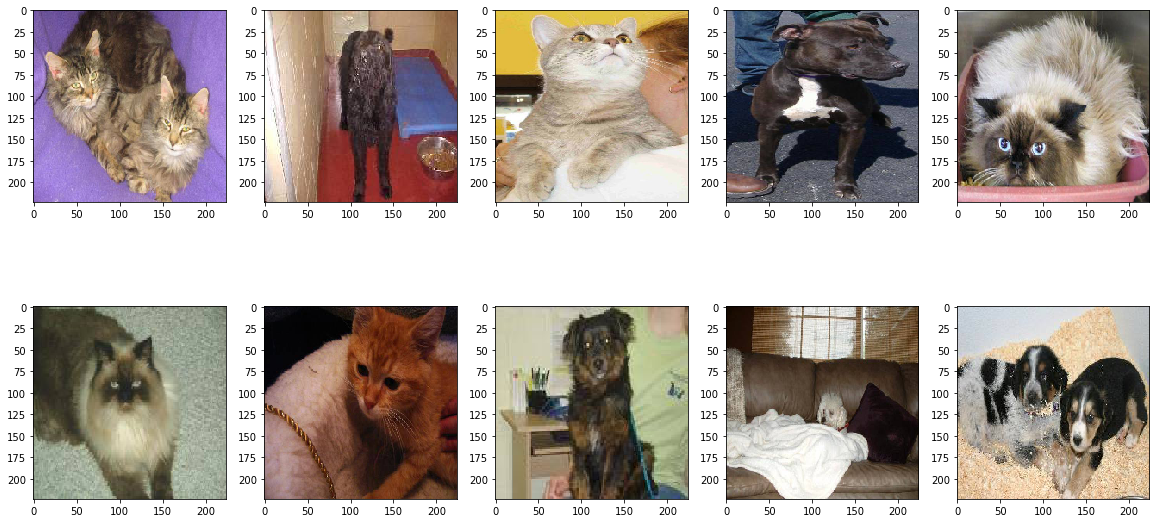

In [3]:
images,labels = batches.next()

fig = plt.figure(figsize=(20,10))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(images[i].astype(np.uint8))

## Transfer Learning

[Stanford Convolution Notes](http://cs231n.github.io/convolutional-networks/)
Inline-style: 
![alt text](https://www.omicsonline.org/articles-images/biometrics-biostatistics-vgg-face-cnn-architecture-7-323-g001.png)

In [5]:
vgg = VGG16()

In [6]:
plot(vgg,'vgg.png',show_shapes=True)

#### Visualize Model

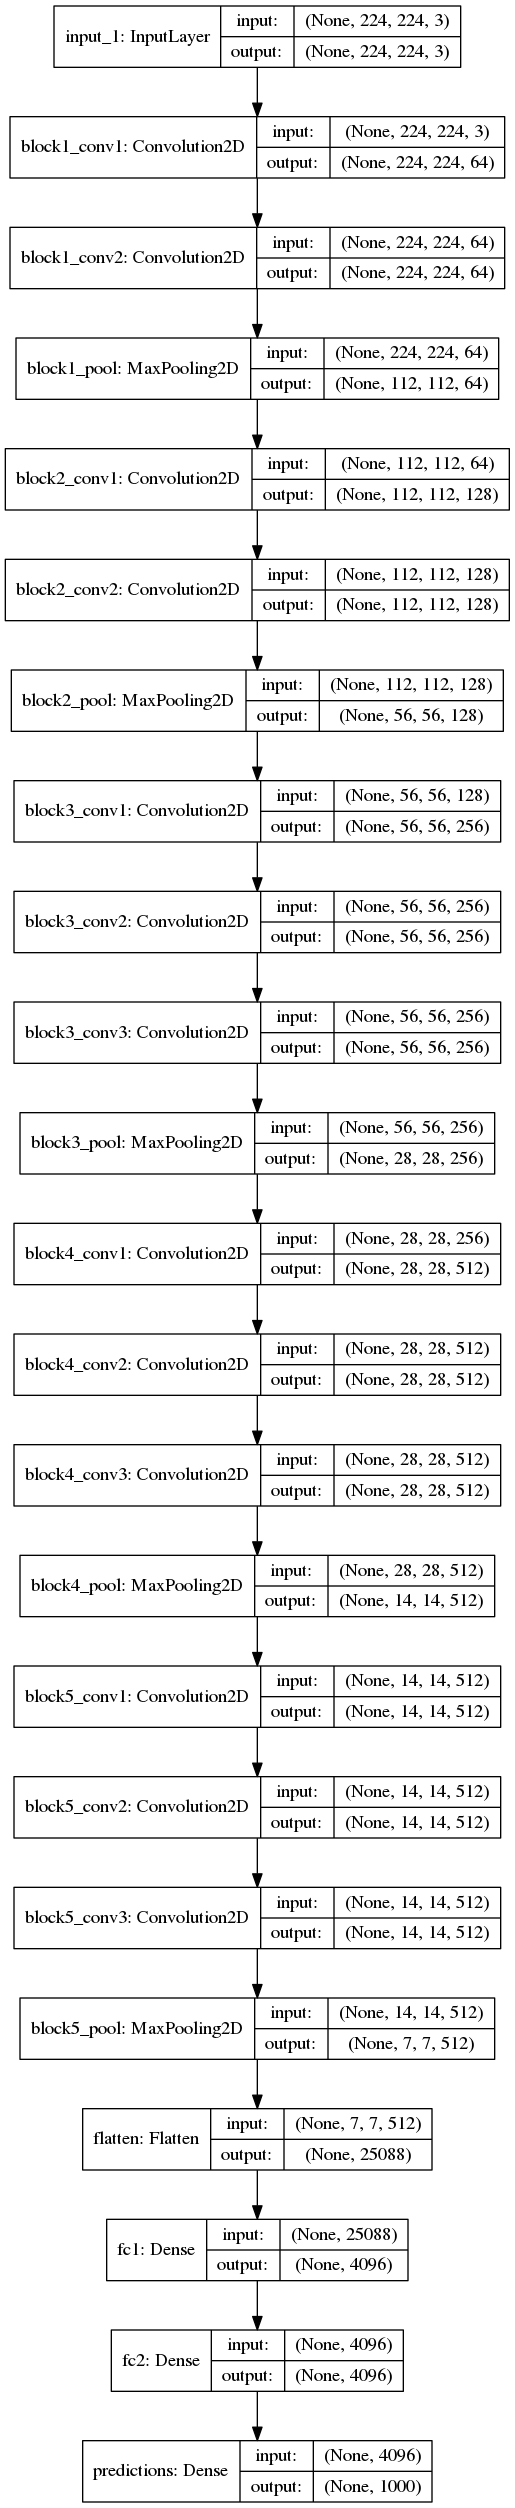

In [7]:
Image.open('vgg.png')

## Fine tuning

In [11]:
vgg = vgg16.VGG16()
layers = vgg.layers[:-1]
for l in layers:
    l.trainable = False
model = Sequential(layers)
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='Adam',metrics=(['accuracy']),loss='categorical_crossentropy')

In [12]:
model.fit_generator(batches,samples_per_epoch=batches.n,nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 183s - loss: 0.1248 - acc: 0.9582   


In [13]:
model.save_weights('model.h5')

## Pre convoluted features

In [70]:
gen = image.ImageDataGenerator()
batches = gen.flow_from_directory('data/train/',batch_size=1,target_size=(224,224),shuffle=False)
val_batches = gen.flow_from_directory('data/valid/',batch_size=1,shuffle=False,target_size=(224,224))

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [71]:
conv_model = Sequential(layers[:-3])


In [72]:
conv_features = conv_model.predict_generator(batches,batches.n)
val_conv_features = conv_model.predict_generator(val_batches,val_batches.n)

In [85]:
d1 = bcolz.carray(conv_features,rootdir='data/results/conv_features.bc',mode='w')
d1.flush()
d2 = bcolz.carray(val_conv_features,rootdir='data/results/val_conv_features.bc',mode='w')
d2.flush()

In [73]:
def onehot(x):
    return to_categorical(x)

In [74]:
train_labels = batches.classes
train_labels = onehot(train_labels)
val_labels = val_batches.classes
val_labels = onehot(val_labels)

In [75]:
inp = Input(batch_shape=conv_model.output_shape)
x = Flatten()(inp)
x = Dense(1000,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(500,activation='relu')(x)
x = BatchNormalization()(x)
out = Dense(2,activation='softmax')(x)
dense_model = Model(inp,out)

In [86]:
dense_model.compile(optimizer='Adam',metrics=(['accuracy']),loss='categorical_crossentropy')

In [87]:
hist = dense_model.fit(conv_features,train_labels,validation_data=(val_conv_features,val_labels),nb_epoch=10)

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 17s - loss: 0.0119 - acc: 0.9958 - val_loss: 0.1282 - val_acc: 0.9695
Epoch 2/10
23000/23000 [==============================] - 17s - loss: 0.0103 - acc: 0.9967 - val_loss: 0.1192 - val_acc: 0.9715
Epoch 3/10
23000/23000 [==============================] - 16s - loss: 0.0075 - acc: 0.9978 - val_loss: 0.1079 - val_acc: 0.9730
Epoch 4/10
23000/23000 [==============================] - 17s - loss: 0.0067 - acc: 0.9976 - val_loss: 0.1351 - val_acc: 0.9715
Epoch 5/10
23000/23000 [==============================] - 17s - loss: 0.0054 - acc: 0.9984 - val_loss: 0.1303 - val_acc: 0.9740
Epoch 6/10
23000/23000 [==============================] - 17s - loss: 0.0045 - acc: 0.9987 - val_loss: 0.1552 - val_acc: 0.9735
Epoch 7/10
23000/23000 [==============================] - 17s - loss: 0.0042 - acc: 0.9987 - val_loss: 0.1440 - val_acc: 0.9745
Epoch 8/10
23000/23000 [==============================]

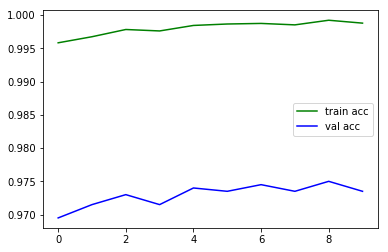

In [90]:
plt.plot(hist.history['acc'],label='train acc',color='green')
plt.plot(hist.history['val_acc'],label='val acc',color='blue')
#plt.autoscale()
plt.legend()

## Avoid over fitting

In [106]:
inp = Input(batch_shape=conv_model.output_shape)
x = Flatten()(inp)
x = Dense(1000,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(500,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(2,activation='softmax')(x)
dense_model = Model(inp,out)
dense_model.compile(optimizer='Adam',metrics=(['accuracy']),loss='categorical_crossentropy')

In [107]:
model.optimizer.lr = 10e-5

In [108]:
hist = dense_model.fit(conv_features,train_labels,validation_data=(val_conv_features,val_labels),nb_epoch=10,verbose=2)

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
17s - loss: 0.1530 - acc: 0.9468 - val_loss: 0.0704 - val_acc: 0.9745
Epoch 2/10
17s - loss: 0.0728 - acc: 0.9715 - val_loss: 0.0750 - val_acc: 0.9720
Epoch 3/10
17s - loss: 0.0551 - acc: 0.9802 - val_loss: 0.1165 - val_acc: 0.9630
Epoch 4/10
17s - loss: 0.0430 - acc: 0.9844 - val_loss: 0.0760 - val_acc: 0.9725
Epoch 5/10
16s - loss: 0.0364 - acc: 0.9868 - val_loss: 0.0943 - val_acc: 0.9685
Epoch 6/10
16s - loss: 0.0325 - acc: 0.9888 - val_loss: 0.0796 - val_acc: 0.9785
Epoch 7/10
17s - loss: 0.0301 - acc: 0.9901 - val_loss: 0.0786 - val_acc: 0.9780
Epoch 8/10
16s - loss: 0.0287 - acc: 0.9906 - val_loss: 0.0878 - val_acc: 0.9745
Epoch 9/10
16s - loss: 0.0239 - acc: 0.9922 - val_loss: 0.0816 - val_acc: 0.9765
Epoch 10/10
17s - loss: 0.0190 - acc: 0.9937 - val_loss: 0.0906 - val_acc: 0.9770


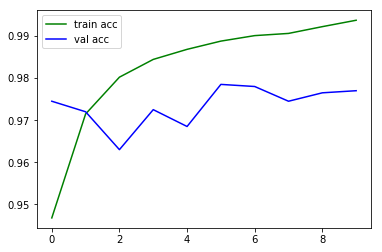

In [109]:
plt.plot(hist.history['acc'],label='train acc',color='green')
plt.plot(hist.history['val_acc'],label='val acc',color='blue')
#plt.autoscale()
plt.legend()

## Data Augmentation

In [7]:
#rescale=1./255,
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
batches = gen.flow_from_directory('data/train/',batch_size=64,target_size=(256,256),shuffle=True)
val_batches = gen.flow_from_directory('data/valid/',batch_size=64,shuffle=False,target_size=(256,256))

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


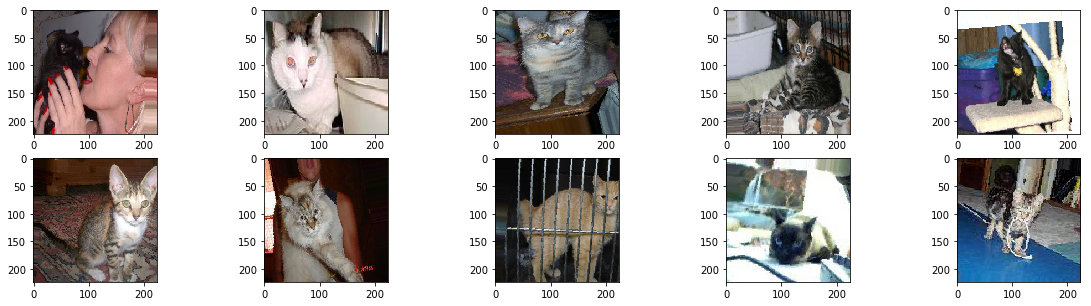

In [16]:
images,labels = batches.next()

fig = plt.figure(figsize=(20,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(images[i].astype(np.uint8))

In [3]:
vgg = vgg16.VGG16(include_top=False,input_shape=(256,256,3))


In [4]:
layers = vgg.layers
for l in layers:
    l.trainable = False
model = Sequential(layers)
m1 = Sequential([
                Flatten(batch_input_shape=model.output_shape),
                Dense(1024, activation='relu'),
                BatchNormalization(),
                Dropout(0.3),
                Dense(1024, activation='relu'),
                BatchNormalization(),
                Dropout(0.3),
                Dense(2, activation='softmax')])
model.add(m1)
model.compile(optimizer=Adam(lr=10e-3),metrics=(['accuracy']),loss='categorical_crossentropy')

In [5]:
model.fit_generator(batches,samples_per_epoch=batches.n,validation_data=val_batches
                    ,nb_val_samples=val_batches.n,nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 252s - loss: 0.3707 - acc: 0.9633 - val_loss: 8.2514 - val_acc: 0.4680


In [ ]:
model.fit_generator(batches,samples_per_epoch=batches.n,validation_data=val_batches
                    ,nb_val_samples=val_batches.n,nb_epoch=10)

Epoch 1/10
23000/23000 [==============================] - 243s - loss: 1.6120 - acc: 0.8725 - val_loss: 0.1851 - val_acc: 0.9510
Epoch 2/10
23000/23000 [==============================] - 238s - loss: 0.1406 - acc: 0.9490 - val_loss: 0.0862 - val_acc: 0.9705
Epoch 3/10
23000/23000 [==============================] - 238s - loss: 0.1059 - acc: 0.9592 - val_loss: 0.0978 - val_acc: 0.9645
Epoch 4/10
23000/23000 [==============================] - 238s - loss: 0.0928 - acc: 0.9643 - val_loss: 0.0764 - val_acc: 0.9680
Epoch 5/10
23000/23000 [==============================] - 238s - loss: 0.0874 - acc: 0.9670 - val_loss: 0.0751 - val_acc: 0.9745
Epoch 6/10
23000/23000 [==============================] - 239s - loss: 0.0745 - acc: 0.9721 - val_loss: 0.0793 - val_acc: 0.9715
Epoch 7/10
23000/23000 [==============================] - 238s - loss: 0.0722 - acc: 0.9730 - val_loss: 0.0738 - val_acc: 0.9740
Epoch 8/10
23000/23000 [==============================] - 246s - loss: 0.0682 - acc: 0.9732 - val

In [ ]:
model.optimizer.lr = 10e-6

In [ ]:
model.fit_generator(batches,samples_per_epoch=batches.n,validation_data=val_batches
                    ,nb_val_samples=val_batches.n,nb_epoch=10)